In [1]:
pip install feature-engine

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from feature_engine import missing_data_imputers as mdi
from feature_engine import variable_transformers as vt

In [3]:
#importing data and exploring it
path='../input/titanic/'
train_data=pd.read_csv('../input/titanic/train.csv')
test_data=pd.read_csv('../input/titanic/test.csv')
print(train_data.shape)
print(test_data.shape)
print(train_data.info())
train_data.head()


(891, 12)
(418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.shape

(891, 12)

In [5]:
train_data.columns
cols_to_use=[ 'Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] #dropping ID variable

# let's separate into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    train_data[cols_to_use],  
    train_data['Survived'],  
    test_size=0.15,  #15% data is used for testing of model accuracy
    random_state=0) 

print(X_train.shape)
print(X_val.shape)
full_data=[X_train,X_val]

(757, 10)
(134, 10)


**Missing value imputation**

In [6]:
missing_val_cols=X_train.columns[X_train.isnull().sum()>0]
X_train.isnull().mean().sort_values(ascending=False)

Cabin       0.776750
Age         0.198151
Embarked    0.002642
Fare        0.000000
Ticket      0.000000
Parch       0.000000
SibSp       0.000000
Sex         0.000000
Name        0.000000
Pclass      0.000000
dtype: float64

20% Age values are missing in both test and validation data.
Missing values in Embarked column is very less so these can be replaced by Mode.
Cabin has 75-80% missing values in both test and valdation set. So these can be labeled as missing.

In [7]:
#Let's calculate number of unique categories for each categorical variable
cat_var=list(X_train.select_dtypes(include=['object']).columns)
for i in list(X_train.select_dtypes(include=['object']).columns):
    print('X_train')
    print(i)
    print(X_train[i].nunique())
    print('X_val')
    print(i)
    print(X_val[i].nunique())

X_train
Name
757
X_val
Name
134
X_train
Sex
2
X_val
Sex
2
X_train
Ticket
605
X_val
Ticket
127
X_train
Cabin
130
X_val
Cabin
35
X_train
Embarked
3
X_val
Embarked
3


Name and ticket variable doesn't seem important to predict survival. So dropping these variables is a good option.

Cabin has very high cardinality so let's capture the first letter of cabin to remove it. While doing this will capture n from nan values(missing data) but it could be a separate category because it has 75.60% of total data.

In [8]:
# let's capture the first letter of Cabin to remove cardinality
X_train['Cabin_reduced'] = X_train['Cabin'].astype(str).str[0]
X_val['Cabin_reduced'] =X_val['Cabin'].astype(str).str[0]


#Name and Ticket column doesn't seem to be important
#so drop these two columns, also Cabin has been converted to Cabin_reduced
#so drop cabin variable as well.
X_train.drop(['Cabin','Name','Ticket'],inplace=True,axis=1)
X_val.drop(['Cabin','Name','Ticket'],inplace=True,axis=1)


In [9]:
for i in list(X_train.select_dtypes(include=['object']).columns):
    print('X_train')
    print(i)
    print(X_train[i].nunique())
    print('X_val')
    print(i)
    print(X_val[i].nunique())

X_train
Sex
2
X_val
Sex
2
X_train
Embarked
3
X_val
Embarked
3
X_train
Cabin_reduced
9
X_val
Cabin_reduced
7


Cabin reduced has 9 categories in train data and 8 categories in Validation data. This issue could be solved by rare label encoding, it will also reduce cardinality.

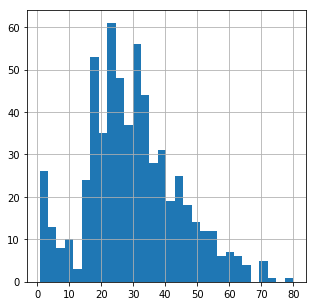

In [10]:
#plot age data for train set
X_train['Age'].hist(bins=30, figsize=(5,5))
plt.show()

Age variable is slightly skewed so missing values can be imputed by median of data. 

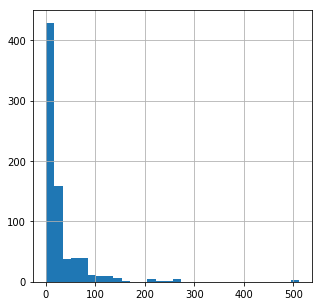

In [11]:
#Plot Fare variable
X_train['Fare'].hist(bins=30, figsize=(5,5))
plt.show()

In [12]:
X_train.isnull().mean()

Pclass           0.000000
Sex              0.000000
Age              0.198151
SibSp            0.000000
Parch            0.000000
Fare             0.000000
Embarked         0.002642
Cabin_reduced    0.000000
dtype: float64

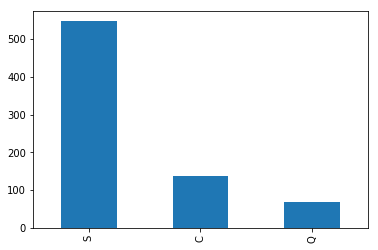

In [13]:
X_train['Embarked'].value_counts().plot(kind='bar')

In [14]:
pipe_1 = Pipeline([
    ('Rare Label .03',RareLabelCategoricalEncoder(
    tol=0.03,n_categories=3,variables=[ 'Cabin_reduced'])
    ),
    ('imputer_median',mdi.MeanMedianImputer(imputation_method='median',variables=['Age','Fare'])),
    ('imputer_mode', mdi.FrequentCategoryImputer(variables=['Embarked']))
])
pipe_1.fit(X_train)
X_train = pipe_1.transform(X_train)
X_val = pipe_1.transform(X_val)

In [15]:
X_train.isnull().mean()

Pclass           0.0
Sex              0.0
Age              0.0
SibSp            0.0
Parch            0.0
Fare             0.0
Embarked         0.0
Cabin_reduced    0.0
dtype: float64

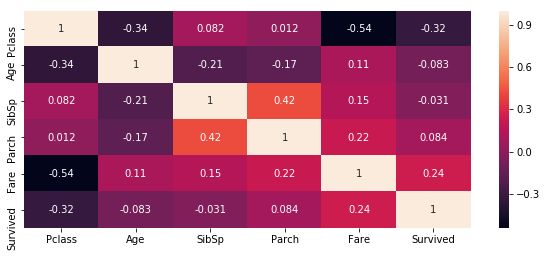

In [16]:
data=X_train.join(y_train)
fig=plt.figure(figsize=(10,4))
sns.heatmap(data.corr(),annot=True)

Fare and passenger class has a very high negative correlation. It means 1st class has highest fare while the 3rd class has lowest fare. To eliminate the multicollinearity Pclass variable is dropped and Fare will be kept as it is.

In [17]:
X_train.drop(['Pclass'],inplace=True,axis=1)
X_val.drop(['Pclass'],inplace=True,axis=1)


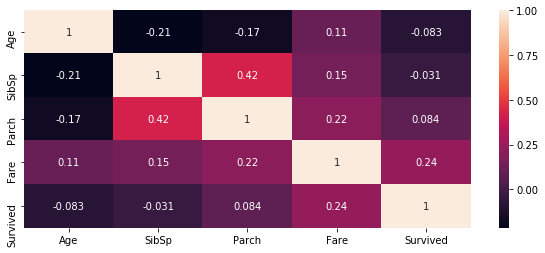

In [18]:
data=X_train.join(y_train)
fig=plt.figure(figsize=(10,4))
sns.heatmap(data.corr(),annot=True)

**Data Visualization**

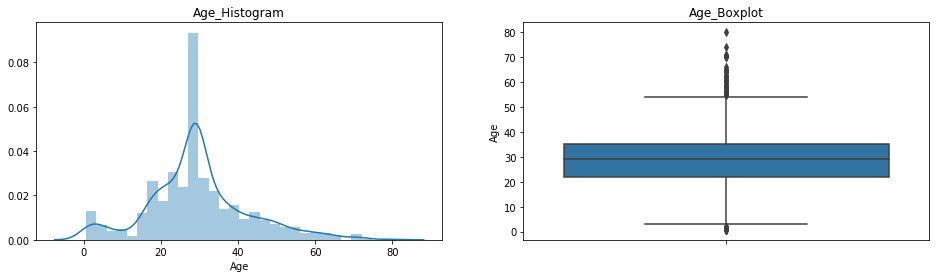

In [19]:
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.distplot(X_train['Age'], bins=30)
    plt.title('Age_Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=X_train['Age'])
    plt.title('Age_Boxplot')

    plt.show()

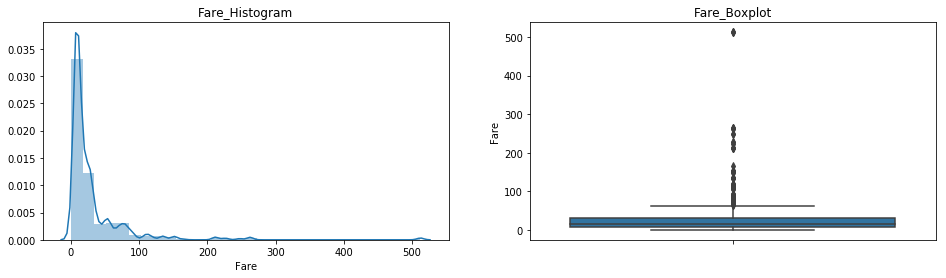

In [20]:
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.distplot(X_train['Fare'], bins=30)
    plt.title('Fare_Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=X_train['Fare'])
    plt.title('Fare_Boxplot')

    plt.show()

In [21]:
#function for outlier handling by capping
def find_boundaries(df, variable):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)

    return upper_boundary, lower_boundary

In [22]:
#outliers handling
vars_with_outliers=[['Age','Fare']]
for i in vars_with_outliers:
    upper_limit, lower_limit = find_boundaries(X_train, i)
    X_train[i]= np.where(X_train[i] > upper_limit, upper_limit,
                       np.where(X_train[i]< lower_limit,lower_limit, X_train[i]))
    X_val[i]= np.where(X_val[i] > upper_limit, upper_limit,
                       np.where(X_val[i]< lower_limit,lower_limit, X_val[i]))

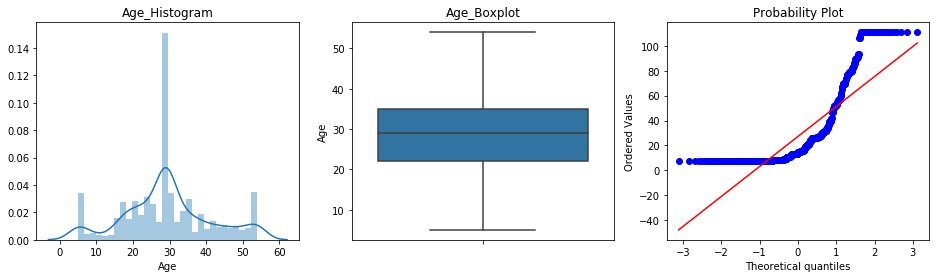

In [23]:
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(X_train['Age'], bins=30)
    plt.title('Age_Histogram')

    # boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=X_train['Age'])
    plt.title('Age_Boxplot')

    # Q-Q Plot
    plt.subplot(1, 3, 3)
    stats.probplot(X_train['Fare'], dist="norm", plot=plt)

    plt.show()

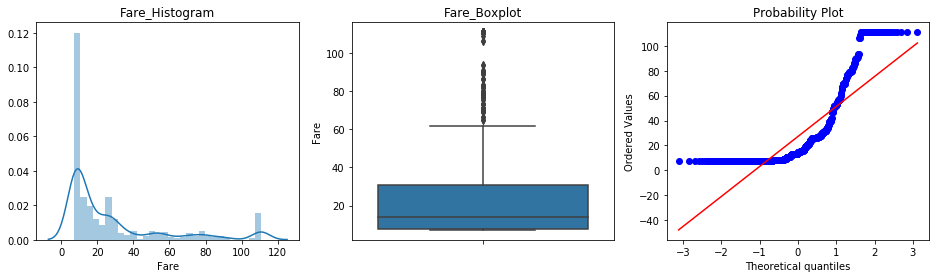

In [24]:
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(X_train['Fare'], bins=30)
    plt.title('Fare_Histogram')

    # boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=X_train['Fare'])
    plt.title('Fare_Boxplot')

    # Q-Q Plot
    plt.subplot(1, 3, 3)
    stats.probplot(X_train['Fare'], dist="norm", plot=plt)

    plt.show()

In [25]:
cols_tf=['Age','Fare']
yjt = vt.YeoJohnsonTransformer(variables = ['Age','Fare'])
yjt.fit(X_train)
X_train = yjt.transform(X_train)
X_val=yjt.transform(X_val)

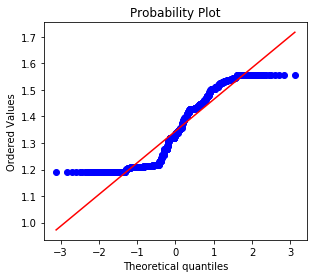

In [26]:
    # Q-Q Plot
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 3)
    stats.probplot(X_train['Fare'], dist="norm", plot=plt)

    plt.show()

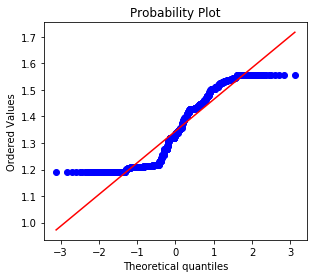

In [27]:
    # Q-Q Plot
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 3)
    stats.probplot(X_train['Fare'], dist="norm", plot=plt)

    plt.show()

**Feature engineering**

In [28]:
X_train.shape

(757, 7)

In [29]:
ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    drop_last=True)

ohe_enc.fit(X_train)
X_train=ohe_enc.transform(X_train)
X_val=ohe_enc.transform(X_val)
print(X_train.shape)
print(X_val.shape)



(757, 12)
(134, 12)


**Logistic Regression Model**

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
classifier=LogisticRegression()
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_val)

cm=confusion_matrix(y_val,y_pred)
cm

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[67, 12],
       [14, 41]])

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        79
           1       0.77      0.75      0.76        55

    accuracy                           0.81       134
   macro avg       0.80      0.80      0.80       134
weighted avg       0.81      0.81      0.81       134



**Random Forest**

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
classifier_random_forest = RandomForestClassifier()
parameters_random_forest = [{'n_estimators': [80,85,90,95,100], 'criterion': ['gini','entropy']}]
grid_search_random_forest = GridSearchCV(estimator = classifier_random_forest,
                           param_grid = parameters_random_forest,
                           scoring = 'accuracy',
                           cv = 10)
grid_search_random_forest = grid_search_random_forest.fit(X_train, y_train)
best_accuracy_random_forest = grid_search_random_forest.best_score_
best_parameters_random_forest = grid_search_random_forest.best_params_
best_parameters_random_forest

{'criterion': 'gini', 'n_estimators': 90}

In [33]:
classifier_random_forest = RandomForestClassifier(n_estimators = 95, criterion = 'gini', random_state = 0)
classifier_random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=95,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [34]:
y_pred_random_forest = classifier_random_forest.predict(X_val)
cm_random_forest = confusion_matrix(y_val, y_pred_random_forest)
print(classification_report(y_val, y_pred_random_forest ))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        79
           1       0.81      0.71      0.76        55

    accuracy                           0.81       134
   macro avg       0.81      0.80      0.80       134
weighted avg       0.81      0.81      0.81       134

